# Required Libraries 

In [30]:
# for analysis and visulaisation 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import re

import wordcloud

# Muting warnings
import warnings
warnings.filterwarnings('ignore')

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# For building our Models
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# For creating vocabulary dictionary:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For model evaluation:
from sklearn.metrics import confusion_matrix,classification_report

# For Text Processing:
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

plt.style.use('fivethirtyeight')

# Loading data

In [31]:
data = pd.read_csv('dataset.csv')

In [32]:
data.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


# Data Exploraton 

# Mising Values

In [33]:
def missing_value_of_data(df):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [34]:
missing_value_of_data(data)

,Total,Percentage
text,0,0.0
humor,0,0.0


# Count Values 

In [35]:
def count_values_in_column(df,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1, keys=['Total','Percentage'])

In [36]:
count_values_in_column(data,'humor')

,Total,Percentage
False,100000,50.0
True,100000,50.0


# Unique Values 

In [37]:
def unique_values_in_column(df,feature):
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

In [38]:
unique_values_in_column(data,'humor')

,Unique Values
0,False
1,True


# Duplicate Values 

In [39]:
def duplicated_values_data(df):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])

In [40]:
duplicated_values_data(data)

,Columns,Duplicate count
0,text,0
1,humor,199998


# Stat

In [41]:
data.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


# Cleaning texts

In [42]:
# removing contracted forms 
import contractions

data["text"] = data["text"].apply(lambda x: contractions.fix(x))

In [43]:
import re
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_punct(text):
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)

def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [ ]:
#codes taken/originate from and link 
#rewriet


In [44]:
data["text"] = data["text"].apply(lambda x: remove_URL(x))
data["text"] = data["text"].apply(lambda x: remove_html(x))
data["text"] = data["text"].apply(lambda x: remove_non_ascii(x))
data["text"] = data["text"].apply(lambda x: remove_punct(x))
data["text"] = data["text"].apply(lambda x: other_clean(x))

# Stopwords removal

In [45]:
# removing stopwords 
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['removed_stopwords'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# lemmatization 

In [46]:
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
data['lemmatized'] = data['removed_stopwords'].apply(lambda x: word_lemmatizer(x))

,text,humor,removed_stopwords,lemmatized
0,Joe biden rules out 2020 bid guys i am not run...,False,Joe biden rules 2020 bid guys running,"[J, o, e, , b, i, d, e, n, , r, u, l, e, s, ..."
1,Watch darvish gave hitter whiplash with slow p...,False,Watch darvish gave hitter whiplash slow pitch,"[W, a, t, c, h, , d, a, r, v, i, s, h, , g, ..."
2,What do you call a turtle without its she will...,True,What call turtle without dead,"[W, h, a, t, , c, a, l, l, , t, u, r, t, l, ..."
3,5 reasons the 2016 election feels so personal,False,5 reasons 2016 election feels personal,"[5, , r, e, a, s, o, n, s, , 2, 0, 1, 6, , ..."
4,Pasco police shot mexican migrant from behind ...,False,Pasco police shot mexican migrant behind new a...,"[P, a, s, c, o, , p, o, l, i, c, e, , s, h, ..."


In [47]:
data['clean_texts'] = data['lemmatized'].apply(lambda x: ' '.join(x))
data

,text,humor,removed_stopwords,lemmatized,clean_texts
0,Joe biden rules out 2020 bid guys i am not run...,False,Joe biden rules 2020 bid guys running,"[J, o, e, , b, i, d, e, n, , r, u, l, e, s, ...",J o e b i d e n r u l e s 2 0 2 0 b i ...
1,Watch darvish gave hitter whiplash with slow p...,False,Watch darvish gave hitter whiplash slow pitch,"[W, a, t, c, h, , d, a, r, v, i, s, h, , g, ...",W a t c h d a r v i s h g a v e h i t t ...
2,What do you call a turtle without its she will...,True,What call turtle without dead,"[W, h, a, t, , c, a, l, l, , t, u, r, t, l, ...",W h a t c a l l t u r t l e w i t h o u ...
3,5 reasons the 2016 election feels so personal,False,5 reasons 2016 election feels personal,"[5, , r, e, a, s, o, n, s, , 2, 0, 1, 6, , ...",5 r e a s o n s 2 0 1 6 e l e c t i o n ...
4,Pasco police shot mexican migrant from behind ...,False,Pasco police shot mexican migrant behind new a...,"[P, a, s, c, o, , p, o, l, i, c, e, , s, h, ...",P a s c o p o l i c e s h o t m e x i c ...
...,...,...,...,...,...
199995,Conor maynard seamlessly fits oldschool rb hit...,False,Conor maynard seamlessly fits oldschool rb hit...,"[C, o, n, o, r, , m, a, y, n, a, r, d, , s, ...",C o n o r m a y n a r d s e a m l e s s l ...
199996,How to you make holy water you boil the hell o...,True,How make holy water boil hell,"[H, o, w, , m, a, k, e, , h, o, l, y, , w, ...",H o w m a k e h o l y w a t e r b o i ...
199997,How many optometrists does it take to screw in...,True,How many optometrists take screw lightbulb one...,"[H, o, w, , m, a, n, y, , o, p, t, o, m, e, ...",H o w m a n y o p t o m e t r i s t s t ...
199998,Mcdonalds will officially kick off allday brea...,False,Mcdonalds officially kick allday breakfast oct...,"[M, c, d, o, n, a, l, d, s, , o, f, f, i, c, ...",M c d o n a l d s o f f i c i a l l y k i ...


# Visualising Text Contents 

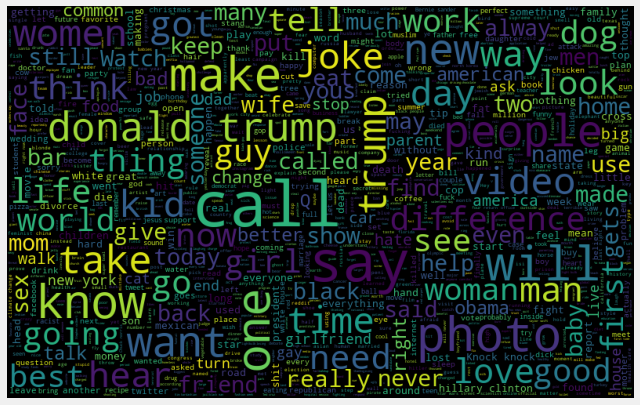

In [17]:
wc = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS,
                    max_font_size=80, max_words=5000, width = 800, height = 500,
                      background_color='black').generate(' '.join(txt for txt in data["text"]))
fig, ax = plt.subplots(figsize=(10,7))
ax.imshow(wc, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wc)

# Plotting top 20 words 

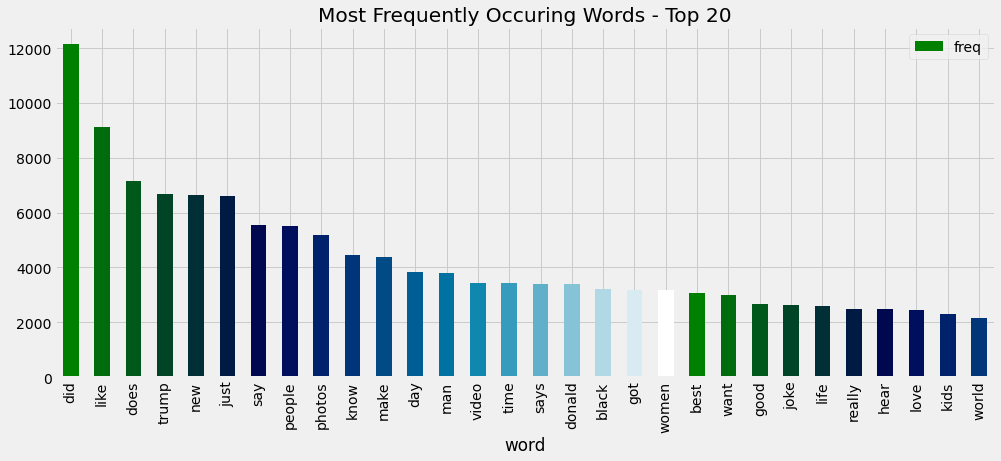

In [18]:
## Visualizing the Most Frequent Words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])


plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

# Splitting data into train and test

In [19]:
train_data, test_data = train_test_split(data[["humor","clean_texts"]], test_size=0.2, random_state=42)

# Tokenisation(Keras)

In [20]:
MAX_NB_WORDS = 10000 # Initializing the maximum number of words to consider as features for tokenizer  
MAX_SEQUENCE_LENGTH = 30 # Initalizing maximum sequence length 
tokenizer = Tokenizer()      # Creating the Tokenizer Object
class Tokenization():
  
    def __init__(self, train_data, test_data, tokenizer):
        self.train_data=train_data
        self.test_data=test_data
        self.tokenizer=tokenizer
      
    
    def padding_sequence(self):
        self.tokenizer.fit_on_texts(self.train_data.clean_texts)     ## Whole text is passed into the object 
        x_train =pad_sequences(self.tokenizer.texts_to_sequences(self.train_data.clean_texts),maxlen = MAX_SEQUENCE_LENGTH)
        x_test =pad_sequences(self.tokenizer.texts_to_sequences(self.test_data.clean_texts),maxlen = MAX_SEQUENCE_LENGTH)
        word_index =self.tokenizer.word_index  ### Tries to create a dictionary of vocabulary 
        vocab_size = len(self.tokenizer.word_index) + 1 # Total unique words in our data
        
        return x_train, x_test, word_index, vocab_size
    
x_train, x_test, word_index, vocab_size = Tokenization(train_data, test_data, tokenizer).padding_sequence()

# Encoding Target

In [21]:
def encoding_target(df):
    encoder = LabelEncoder()
    encoder.fit(train_data.humor.to_list())
    y_train = encoder.transform(train_data.humor.to_list())
    y_test = encoder.transform(test_data.humor.to_list())
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1) 
    return x_train, x_test, y_train, y_test 

In [22]:
x_train, x_test, y_train, y_test = encoding_target(data)

# GloVe Embedding 

In [23]:
# Creating an embedding matrix based on our Tokeniser object
embeddings_index = {}
embedding_dim=100
def get_embedding_matrix(word_index,vocab_size):
    with open('glove.6B.100d.txt', encoding="utf8") as file:
        for line in file:
            values = line.split()
            word = value = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
            
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, i in word_index.items():  
        
        embedding_vector = embeddings_index.get(word)  
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

embedding_matrix = get_embedding_matrix(word_index, vocab_size)

# Comparing  Traditional Machine Learning Algorithms
__(KNeighbors, XGBoost, RandomForest, DecisionTree, Support Vector Machine)__

In [24]:
models = []
models.append(('SVM', LinearSVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTC', DecisionTreeClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=None)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

SVM: 0.515125 (0.039902)
KNN: 0.616369 (0.002804)
XGB: 0.842263 (0.001336)
RFC: 0.805675 (0.001384)
DTC: 0.752787 (0.004189)


# LSTM

In [25]:
model=tf.keras.Sequential()

model.add(Input(shape=[MAX_SEQUENCE_LENGTH]))
model.add(Embedding(vocab_size,100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH))    

model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.5))

model.add(tf.keras.layers.Dense(1,activation='sigmoid')) #output layer

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           6458400   
                                                                 
 lstm (LSTM)                 (None, 30, 200)           240800    
                                                                 
 dropout (Dropout)           (None, 30, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 200)           320800    
                                                                 
 dropout_1 (Dropout)         (None, 30, 200)           0         
                                                                 
 dense (Dense)               (None, 30, 1)             201       
                                                                 
Total params: 7,020,201
Trainable params: 7,020,201
Non-

In [27]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
history = model.fit(x_train,y_train,batch_size=100,validation_data=(x_test, y_test),epochs=10)

Epoch 1/5
1600/1600 [==============================] - 536s 332ms/step - loss: 0.5869 - accuracy: 0.5986 - val_loss: 0.5827 - val_accuracy: 0.5986
Epoch 2/5
1600/1600 [==============================] - 511s 319ms/step - loss: 0.5690 - accuracy: 0.6065 - val_loss: 0.5761 - val_accuracy: 0.6027
Epoch 3/5
1600/1600 [==============================] - 506s 316ms/step - loss: 0.5610 - accuracy: 0.6098 - val_loss: 0.5792 - val_accuracy: 0.6020
Epoch 4/5
1600/1600 [==============================] - 509s 318ms/step - loss: 0.5557 - accuracy: 0.6117 - val_loss: 0.5793 - val_accuracy: 0.6024
Epoch 5/5
1600/1600 [==============================] - 509s 318ms/step - loss: 0.5518 - accuracy: 0.6139 - val_loss: 0.5838 - val_accuracy: 0.6022


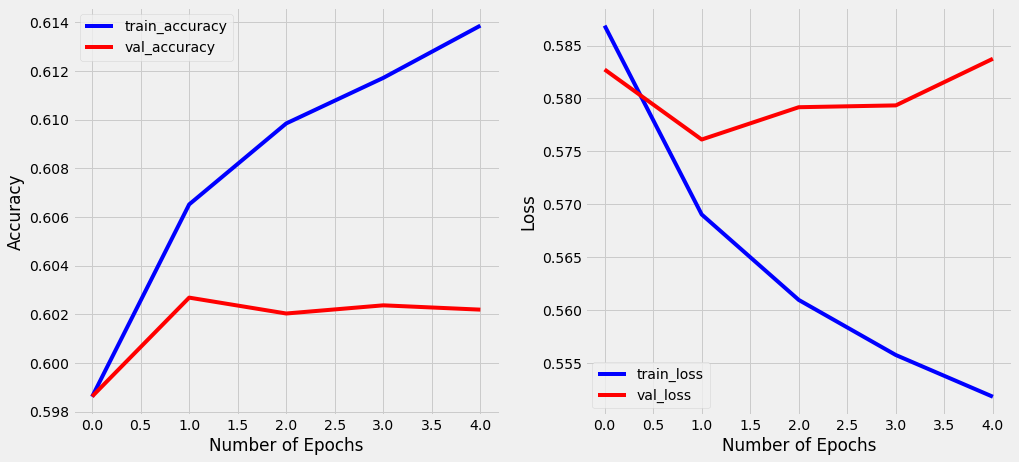

In [29]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].plot(history.history['accuracy'],c= 'b',label="train_accuracy")
ax[0].plot(history.history['val_accuracy'],c= 'r',label="val_accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'],c= 'b',label="train_loss")
ax[1].plot(history.history['val_loss'],c= 'r',label="val_loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()